In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import datetime

In [4]:
path = pathlib.Path().resolve()

In [8]:
vehicle_sales = pd.read_csv(path / "data" / "outputs" / "new_vehicle_sales_month_year_zip.csv")
vehicle_sales = vehicle_sales.drop("Unnamed: 0", axis = 1)

In [15]:
ev_sales = vehicle_sales[vehicle_sales["FuelTypePrimary"] == "Electric"]
ev_sales.loc[:, "day"] = 1

C:\Users\rajan\AppData\Local\Temp\ipykernel_13256\1779703087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_sales.loc[:, "day"] = 1


In [17]:
ev_sales["date"] = pd.to_datetime(ev_sales[["year", "month", "day"]])

C:\Users\rajan\AppData\Local\Temp\ipykernel_13256\1963889170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_sales["date"] = pd.to_datetime(ev_sales[["year", "month", "day"]])


,FuelTypePrimary,ZIP_CODE,VEH_COUNT,year,month,day,date
149,Electric,6001,3,2018,1,1,2018-01-01
150,Electric,6010,1,2018,1,1,2018-01-01
151,Electric,6029,1,2018,1,1,2018-01-01
152,Electric,6032,1,2018,1,1,2018-01-01
153,Electric,6033,4,2018,1,1,2018-01-01
...,...,...,...,...,...,...,...
36261,Electric,6902,28,2022,12,1,2022-12-01
36262,Electric,6903,20,2022,12,1,2022-12-01
36263,Electric,6905,7,2022,12,1,2022-12-01
36264,Electric,6906,2,2022,12,1,2022-12-01


In [29]:
ev_sales_zip_grouped = ev_sales.groupby(["date"]).sum()
ev_sales_zip_grouped = ev_sales_zip_grouped.reset_index()
ev_sales_zip_grouped = ev_sales_zip_grouped[["date", "VEH_COUNT"]]
ev_sales_zip_grouped

,date,VEH_COUNT
0,2018-01-01,278
1,2018-02-01,173
2,2018-03-01,233
3,2018-04-01,331
4,2018-05-01,323
5,2018-06-01,318
6,2018-07-01,314
7,2018-08-01,317
8,2018-09-01,422
9,2018-10-01,569


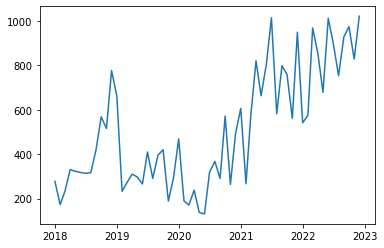

In [31]:
plt.plot(ev_sales_zip_grouped["date"], ev_sales_zip_grouped["VEH_COUNT"])

In [33]:
ev_sales_zip_grouped["month"] = ev_sales_zip_grouped["date"].astype(str).str[5:7]

In [36]:
month_dummy = pd.get_dummies(ev_sales_zip_grouped["month"], prefix='month')
ev_sales_zip_grouped_dummies = pd.concat([ev_sales_zip_grouped, month_dummy], axis = 1)
ev_sales_zip_grouped_dummies = ev_sales_zip_grouped_dummies.iloc[:, ~ev_sales_zip_grouped_dummies.columns.isin(["month"])]

,date,VEH_COUNT,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,2018-01-01,278,1,0,0,0,0,0,0,0,0,0,0,0
1,2018-02-01,173,0,1,0,0,0,0,0,0,0,0,0,0
2,2018-03-01,233,0,0,1,0,0,0,0,0,0,0,0,0
3,2018-04-01,331,0,0,0,1,0,0,0,0,0,0,0,0
4,2018-05-01,323,0,0,0,0,1,0,0,0,0,0,0,0
5,2018-06-01,318,0,0,0,0,0,1,0,0,0,0,0,0
6,2018-07-01,314,0,0,0,0,0,0,1,0,0,0,0,0
7,2018-08-01,317,0,0,0,0,0,0,0,1,0,0,0,0
8,2018-09-01,422,0,0,0,0,0,0,0,0,1,0,0,0
9,2018-10-01,569,0,0,0,0,0,0,0,0,0,1,0,0


In [44]:
ev_sales_zip_grouped_dummies= ev_sales_zip_grouped_dummies.reset_index()

In [46]:
ev_sales_zip_grouped_dummies = ev_sales_zip_grouped_dummies.rename(columns = {"index":"time"})

,time,date,VEH_COUNT,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,0,2018-01-01,278,1,0,0,0,0,0,0,0,0,0,0,0
1,1,2018-02-01,173,0,1,0,0,0,0,0,0,0,0,0,0
2,2,2018-03-01,233,0,0,1,0,0,0,0,0,0,0,0,0
3,3,2018-04-01,331,0,0,0,1,0,0,0,0,0,0,0,0
4,4,2018-05-01,323,0,0,0,0,1,0,0,0,0,0,0,0
5,5,2018-06-01,318,0,0,0,0,0,1,0,0,0,0,0,0
6,6,2018-07-01,314,0,0,0,0,0,0,1,0,0,0,0,0
7,7,2018-08-01,317,0,0,0,0,0,0,0,1,0,0,0,0
8,8,2018-09-01,422,0,0,0,0,0,0,0,0,1,0,0,0
9,9,2018-10-01,569,0,0,0,0,0,0,0,0,0,1,0,0


In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [54]:
[column_name for column_name in ev_sales_zip_grouped_dummies.columns.to_list()[3:]]

['month_01',
 'month_02',
 'month_03',
 'month_04',
 'month_05',
 'month_06',
 'month_07',
 'month_08',
 'month_09',
 'month_10',
 'month_11',
 'month_12']

In [56]:
y_var_name = "VEH_COUNT"
x_var_name = "time"
dummies = '+'.join([column_name for column_name in ev_sales_zip_grouped_dummies.columns.to_list()[3:]])
form = y_var_name+"~"+x_var_name+"+"+dummies
form

'VEH_COUNT~time+month_01+month_02+month_03+month_04+month_05+month_06+month_07+month_08+month_09+month_10+month_11+month_12'

In [71]:
ev_sales_zip_grouped_dummies = ev_sales_zip_grouped_dummies.iloc[:, ~ev_sales_zip_grouped_dummies.columns.isin(["date"])]

In [59]:
lsdv_model = smf.ols(formula=form, data=ev_sales_zip_grouped_dummies)
lsdv_model_results = lsdv_model.fit()
print(lsdv_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:              VEH_COUNT   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     6.394
Date:                Tue, 03 Oct 2023   Prob (F-statistic):           1.49e-06
Time:                        14:44:08   Log-Likelihood:                -391.11
No. Observations:                  60   AIC:                             808.2
Df Residuals:                      47   BIC:                             835.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    182.9228     44.267      4.132      0.0

In [66]:
np.linspace(0,20,21)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [72]:
a = lsdv_model_results.predict(ev_sales_zip_grouped_dummies)

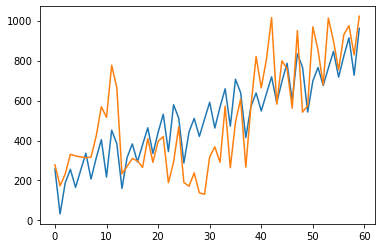

In [75]:
plt.plot(a)
plt.plot(ev_sales_zip_grouped_dummies["VEH_COUNT"])

In [95]:
fake_years = [2018, 2019, 2020, 2021, 2022,2023, 2024, 2025, 2026,2027,2028,2029,2030]
fake_months = [1,2,3,4,5,6,7,8,9,10,11,12]
fake_data = pd.DataFrame([])
i = 0
for year in fake_years:
    for month in fake_months:
        fake_data.loc[i, "year"] = int(year)
        fake_data.loc[i, "month"] = f"{int(month)}".zfill(2)
        fake_data.loc[i, "time"] = int(i)
        i+=1

In [96]:
fake_month_dummies = pd.get_dummies(fake_data["month"], prefix = 'month')
fake_data = pd.concat([fake_data, fake_month_dummies], axis = 1)
fake_data

,year,month,time,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,2018.0,01,0.0,1,0,0,0,0,0,0,0,0,0,0,0
1,2018.0,02,1.0,0,1,0,0,0,0,0,0,0,0,0,0
2,2018.0,03,2.0,0,0,1,0,0,0,0,0,0,0,0,0
3,2018.0,04,3.0,0,0,0,1,0,0,0,0,0,0,0,0
4,2018.0,05,4.0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2030.0,08,151.0,0,0,0,0,0,0,0,1,0,0,0,0
152,2030.0,09,152.0,0,0,0,0,0,0,0,0,1,0,0,0
153,2030.0,10,153.0,0,0,0,0,0,0,0,0,0,1,0,0
154,2030.0,11,154.0,0,0,0,0,0,0,0,0,0,0,1,0


In [97]:
b = lsdv_model_results.predict(fake_data)
b

0       256.816667
1        32.616667
2       188.216667
3       255.616667
4       165.416667
          ...     
151    1737.316667
152    1842.316667
153    1933.916667
154    1746.916667
155    1981.516667
Length: 156, dtype: float64

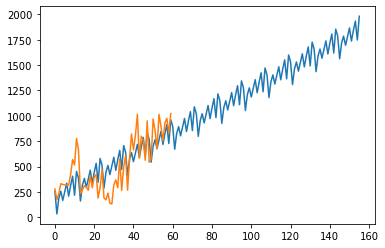

In [100]:
plt.plot(b)
plt.plot(ev_sales_zip_grouped_dummies["VEH_COUNT"])

In [101]:
b.sum()

159361.80000000008

## Do this with quadratic term

In [103]:
ev_sales_zip_grouped_dummies["time2"] = ev_sales_zip_grouped_dummies["time"]**2

In [105]:
form_2 = y_var_name+"~"+x_var_name+"+time2""+"+dummies
form_2

'VEH_COUNT~time+time2+month_01+month_02+month_03+month_04+month_05+month_06+month_07+month_08+month_09+month_10+month_11+month_12'

In [106]:
lsdv_model_2 = smf.ols(formula=form_2, data=ev_sales_zip_grouped_dummies)
lsdv_model_results_2 = lsdv_model_2.fit()
print(lsdv_model_results_2.summary())

                            OLS Regression Results                            
Dep. Variable:              VEH_COUNT   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     9.539
Date:                Tue, 03 Oct 2023   Prob (F-statistic):           3.70e-09
Time:                        15:56:15   Log-Likelihood:                -380.93
No. Observations:                  60   AIC:                             789.9
Df Residuals:                      46   BIC:                             819.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    355.7185     55.070      6.459      0.0

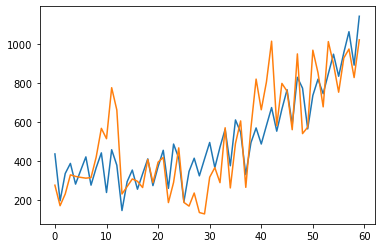

In [110]:
plt.plot(lsdv_model_results_2.predict(ev_sales_zip_grouped_dummies))
plt.plot(ev_sales_zip_grouped_dummies["VEH_COUNT"])

In [111]:
fake_data["time2"]=fake_data["time"]**2

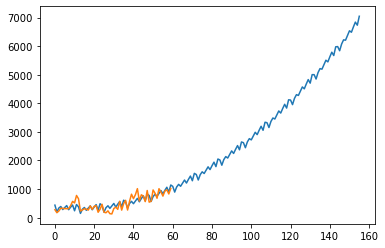

In [112]:
plt.plot(lsdv_model_results_2.predict(fake_data))
plt.plot(ev_sales_zip_grouped_dummies["VEH_COUNT"])

In [113]:
lsdv_model_results_2.predict(fake_data).sum()

365810.2557368327

So this gets us closer to the 500,000 predicted by DEEP